Dot-product

In [1]:
import _pickle as pickle
spectraMapFile = open("/usr/local/hdd/rita/spectraFile.pickle","rb")
pixel_map = pickle.load(spectraMapFile)

In [ ]:
from pyimzml.ImzMLParser import ImzMLParser, browse, getionimage
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import numpy as np
import pytraj as pt
%matplotlib inline

parser = ImzMLParser("/usr/local/hdd/rita/msimaging/181114_AT1_Slide_D_Proteins.imzML")

def tupel2map(spec):
    return dict(zip(spec[0], spec[1])) # m/z -> intensity

def get_peaks(spec):
    #return {key: spec[key] for key in sorted(spec, key=spec.get, reverse=False)[:n]}
    interval = 100#len(spec.keys())//1000
       
    peaks = set()
    
    for intens in pt.tools.n_grams(list(spec.keys()), interval):
        maxI = 0
        maxMZ = 0
        
        epshull = (max(intens)-min(intens))/2
        
        for mz in intens:
            if spec[mz] > maxI:
                maxI = spec[mz]
                maxMZ = mz
        
        tmp = maxMZ
        
        addPeak = True
        if len(peaks) > 0:
            
            #exist already registered peak within epsilon hull with lower intensity?
            for p in peaks:
                
                if abs(p-tmp) < epshull:
                    if spec[p] < spec[tmp]:
                        peaks.remove(p)
                        peaks.add(tmp)
                        addPeak = False
                        break
                    else:
                        
                        addPeak = False
                        break
                        
        if addPeak:
            
            allValues = [spec[mz] for mz in intens]
            if maxI > 5*np.median(allValues):
                peaks.add(tmp)
            
    return np.array(list(peaks))

def get_similarity(spec1, spec2, id_map):
    result = [0,0]
    map_1 = id_map[spec1][0]
    map_2 = id_map[spec2][0]
    
    #Similarity (dot product) of two comlpete spectra
    intens1 = np.array(list(map_1.values()))
    intens2 = np.array(list(map_2.values()))
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)

    result[0] = cos_lib[0][0]

    #Similarity (dot product) of two united peak-spectra
    peaks_spec1 = id_map[spec1][1]
    peaks_spec2 = id_map[spec2][1]
    
    mz = list(set().union(peaks_spec1, peaks_spec2))
    
    mz2int1 = [map_1[x] for x in mz]
    mz2int2 = [map_2[x] for x in mz]
    
    intens1 = np.array(mz2int1)
    intens2 = np.array(mz2int2)  
    
    intens1 = intens1/np.max(intens1)
    intens2 = intens2/np.max(intens2)
    
    intens1 = intens1.reshape(1, len(intens1))
    intens2 = intens2.reshape(1, len(intens2))
    cos_lib = cosine_similarity(intens1, intens2)
    
    result[1] = cos_lib[0][0]

    return result


In [12]:
ids = list(pixel_map.keys())

dot_product_all = np.zeros((len(ids), len(ids)))
dot_product_peaks = np.zeros((len(ids), len(ids)))

for i in range(len(ids)):
    for j in range(i, len(ids)):
        tmp = get_similarity(ids[i], ids[j], pixel_map)
        dot_product_all[i, j] = dot_product_all[j, i] = tmp[0]
        dot_product_peaks[i, j] = dot_product_peaks[j, i] = tmp[1]

In [13]:
dot_product_all_matrix = open("dot_product_all_matrix.pickle","wb")
pickle.dump(dot_product_all, dot_product_all_matrix)

In [14]:
dot_product_peaks_matrix = open("dot_product_peaks_matrix.pickle","wb")
pickle.dump(dot_product_peaks, dot_product_peaks_matrix)

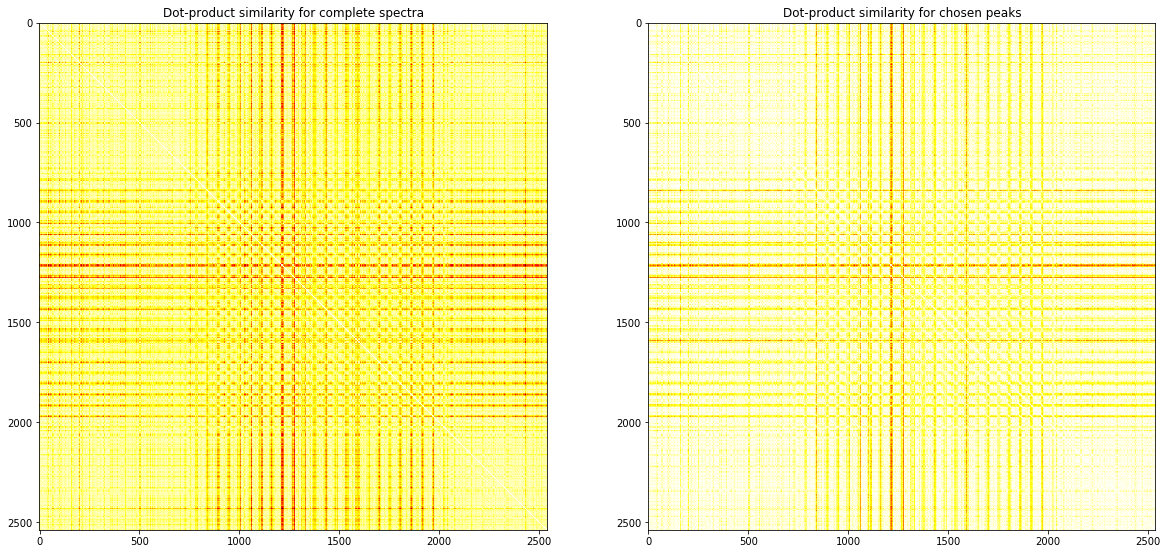

In [40]:
fig = plt.figure(figsize=(20, 30))
fig.add_subplot(1,2,1)
plt.imshow(dot_product_all, cmap='hot', interpolation='nearest')
plt.title('Dot-product similarity for complete spectra')
fig.add_subplot(1,2,2)
plt.imshow(dot_product_peaks, cmap='hot', interpolation='nearest')
plt.title('Dot-product similarity for chosen peaks')
plt.show()   

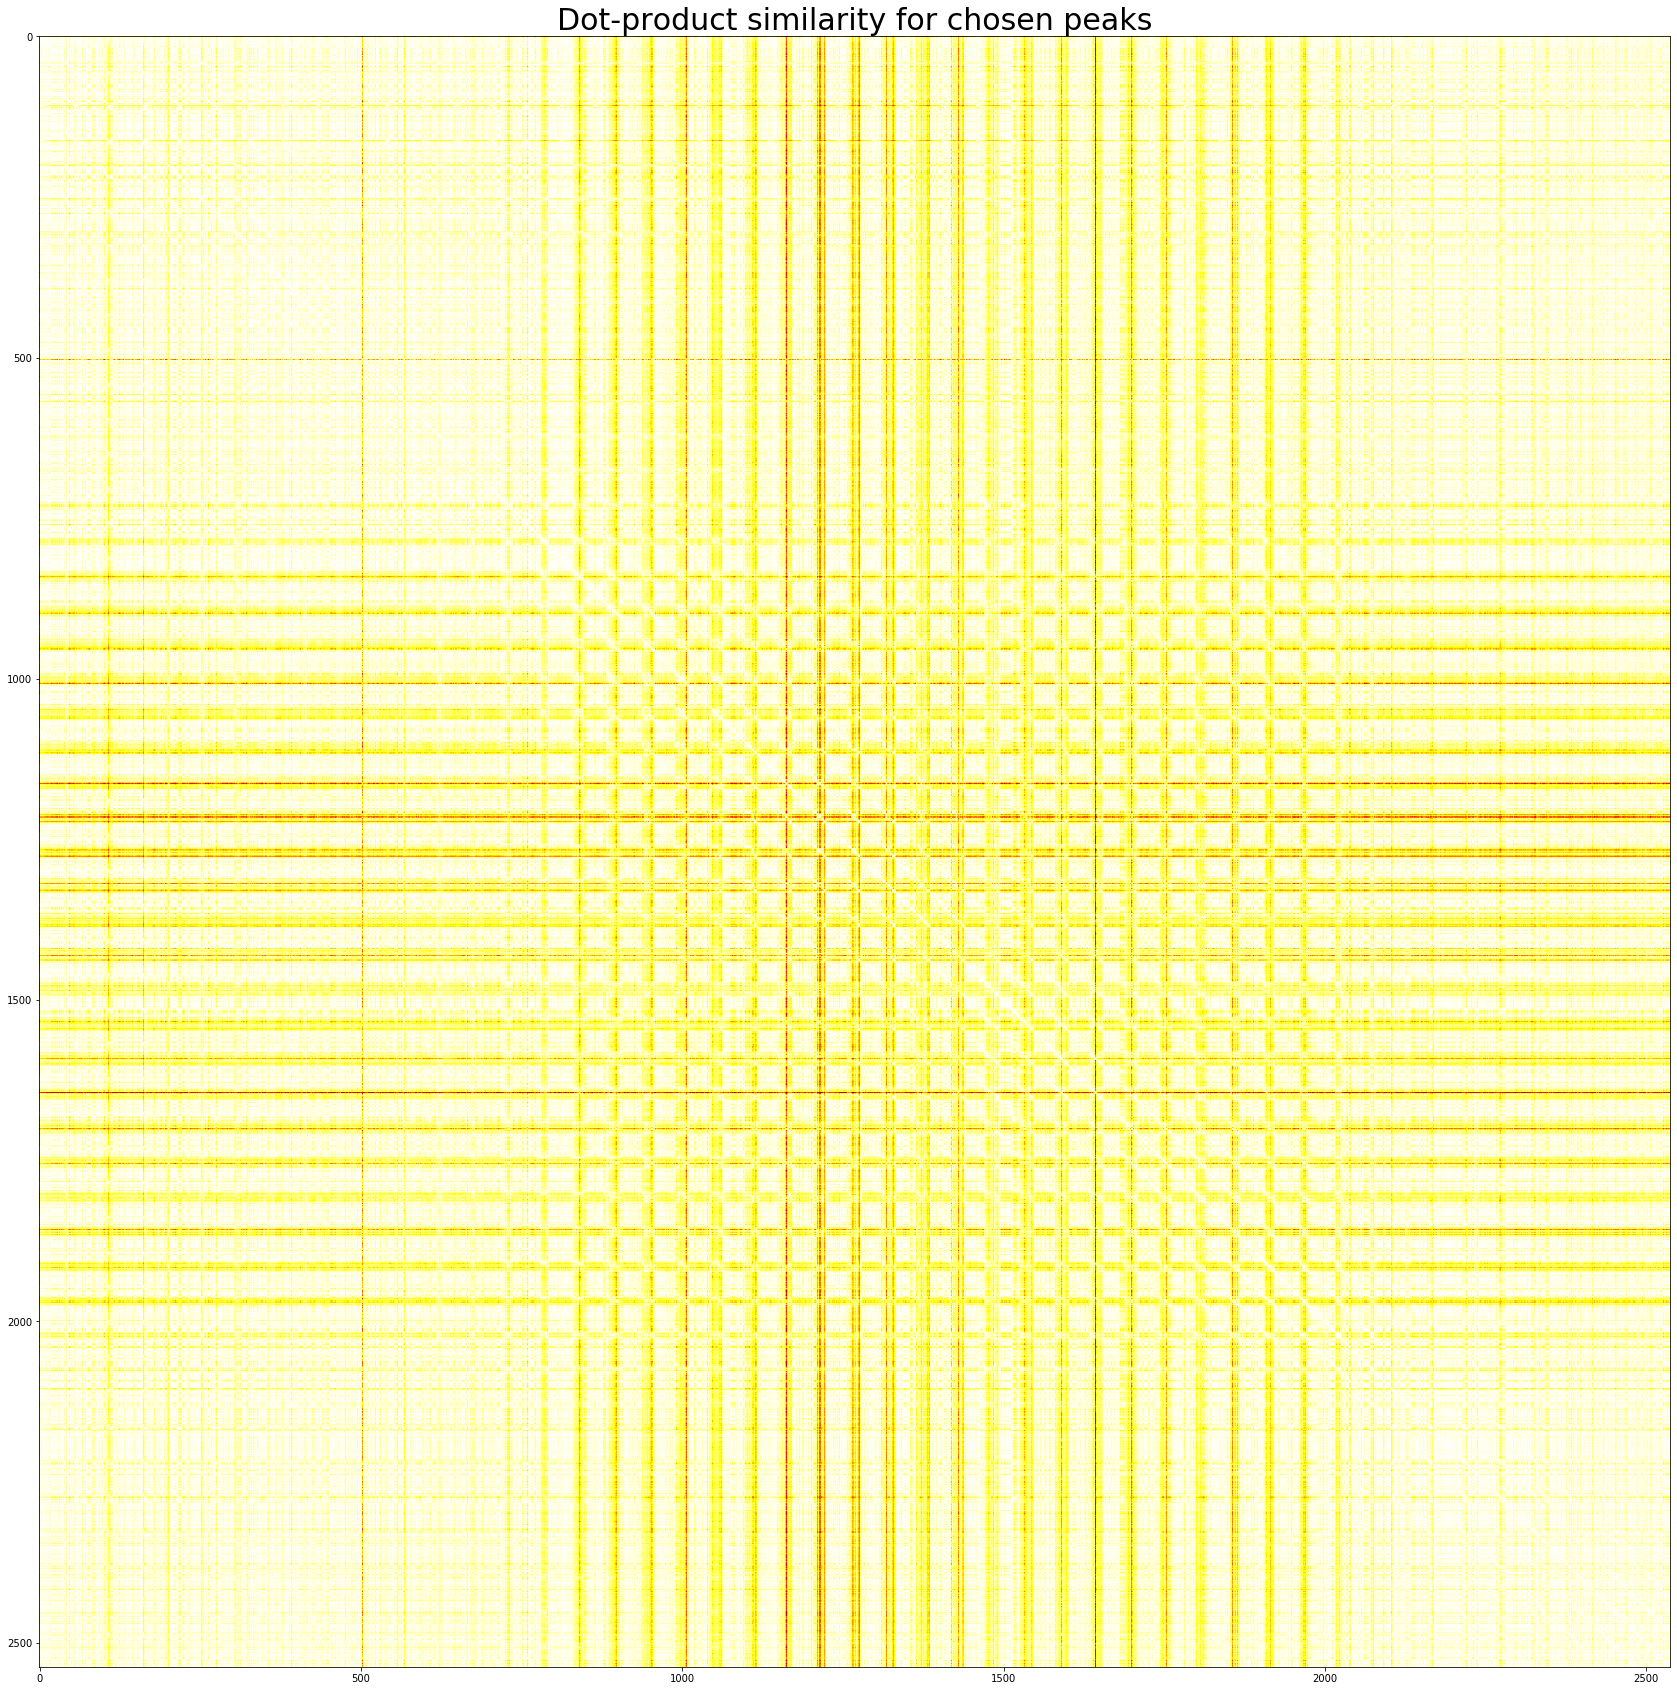

In [41]:
plt.figure(figsize=(30, 30))
plt.imshow(dot_product_all, cmap='hot', interpolation='nearest')
plt.title('Dot-product similarity for complete spectra', fontsize = 30)
plt.savefig('plots/dot_product_all.png')
plt.imshow(dot_product_peaks, cmap='hot', interpolation='nearest')
plt.title('Dot-product similarity for chosen peaks', fontsize = 30)
plt.savefig('plots/dot_product_peaks.png')

In [32]:
import _pickle as pickle
dot_product_all_matrix = open("/usr/local/hdd/rita/similar_methods/dot_product_all_matrix.pickle","rb")
dot_product_all = pickle.load(dot_product_all_matrix)

dot_product_peaks_matrix = open("/usr/local/hdd/rita/similar_methods/dot_product_peaks_matrix.pickle","rb")
dot_product_peaks = pickle.load(dot_product_peaks_matrix)

In [33]:
import numpy as np
unique, counts = np.unique(np.array(dot_product_all), return_counts=True)
d = dict(zip(unique, counts))
d[1.0]

120

In [38]:
len(dot_product_all[dot_product_all >= 0.9999])

2538

In [35]:
np.min(np.min(dot_product_peaks))

0.5089749327193294